In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [2]:
training = spark.read.option("inferSchema","true").csv("Training.csv",header=True)
testing = spark.read.option("inferSchema","true").csv("Testing.csv",header=True)

In [3]:
training = training.select("Algae Concentration", "Oil Concentration", "Trash Pollution")
testing = testing.select("Algae Concentration", "Oil Concentration", "Trash Pollution", "Polluted")

In [4]:
training = training.na.drop()
testing = testing.na.drop()

In [5]:
from pyspark.sql.functions import when

training = training.withColumn("Trash Pollution", when(training["Trash Pollution"] == "Low", 0).
                                                  when(training["Trash Pollution"] == "Medium", 1).
                                                  when(training["Trash Pollution"] == "High", 2))

testing = testing.withColumn("Trash Pollution", when(testing["Trash Pollution"] == "Low", 0).
                                                when(testing["Trash Pollution"] == "Medium", 1).
                                                when(testing["Trash Pollution"] == "High", 2))

testing = testing.withColumn("Polluted", when(testing["Polluted"] == "No", 0).
                                         when(testing["Polluted"] == "Yes", 1))

In [12]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

colsTrain = training.columns
colsTest = testing.columns
colsTest.remove("Polluted")

training = VectorAssembler(inputCols = colsTrain, outputCol = "Vector").transform(training)
testing = VectorAssembler(inputCols = colsTest, outputCol = "Vector").transform(testing)

In [13]:
scaler = StandardScaler(inputCol = "Vector", outputCol = "features")
training = scaler.fit(training).transform(training)
testing = scaler.fit(testing).transform(testing)

In [14]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans().setK(2)
model = kmeans.fit(training)
predictions = model.transform(testing)

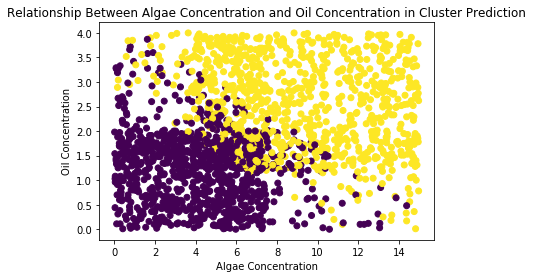

In [15]:
predictions = predictions.toPandas()
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(predictions["Algae Concentration"], predictions["Oil Concentration"], c=predictions["prediction"])
ax.set_title('Relationship Between Algae Concentration and Oil Concentration in Cluster Prediction')
ax.set_xlabel('Algae Concentration')
ax.set_ylabel('Oil Concentration')
plt.show()

In [16]:
c = 0
for index, row in predictions.iterrows():
    if row["Polluted"] == row["prediction"]:
        c = c + 1

print("Accuracy: {}%".format(c / len(predictions) * 100))

Accuracy: 80.88004190675746%
